# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [74]:
import pandas as pd
import numpy as np
import cv2
import os
from google.colab import drive
import keras
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Reshape, BatchNormalization
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon
from keras import Model
import tensorflow as tf

### Change directory

In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
os.getcwd()

'/content'

In [11]:
project_path = "./drive/My Drive/AIML/ACV/ACV Lab Questions and Data Set/ACV Lab Questions and Data Set/"
print(project_path)

os.chdir(project_path)

./drive/My Drive/AIML/ACV/ACV Lab Questions and Data Set/ACV Lab Questions and Data Set/


In [12]:
os.getcwd()

'/content/drive/My Drive/AIML/ACV/ACV Lab Questions and Data Set/ACV Lab Questions and Data Set'

### Load the training data from train.csv file

In [17]:
df = pd.read_csv('train_labels.csv')


(173, 8)

### Print the shape of the train dataset

In [18]:
df.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [19]:
IMAGE_SIZE=128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [45]:
TRAIN_CSV=project_path+'train_labels.csv'
IMAGES_ZIP_PATH = project_path+'images_racoon.rar'
print(TRAIN_CSV)
print(IMAGES_ZIP_PATH)

./drive/My Drive/AIML/ACV/ACV Lab Questions and Data Set/ACV Lab Questions and Data Set/train_labels.csv
./drive/My Drive/AIML/ACV/ACV Lab Questions and Data Set/ACV Lab Questions and Data Set/images_racoon.rar


In [40]:
# !pip install unrar
# !pip install rarfile


In [47]:
from rarfile import  RarFile
with RarFile('images_racoon.rar') as rf:
  rf.extractall()

In [56]:
import csv
with open('train_labels.csv','r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile) - 1, 4))
    #print(coords)
    spamreader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(spamreader, None)
    for i,row in enumerate(spamreader):
        #print(row)
        for j, r in enumerate(row): # Parse row with seven entities
            #print(i)
            if((j!= 0) & (j!=3)):
                row[j] = int(r)
            
        #print(row)      
        path, width, height, class_, xmin, ymin, xmax, ymax = row
        paths.append(path)
        #print(i)
        coords[i,0] = xmin * IMAGE_SIZE / width
        coords[i,1] = ymin * IMAGE_SIZE / height
        coords[i,2] = xmax * IMAGE_SIZE / width # Normalize bounding box by image size
        coords[i,3] = ymax * IMAGE_SIZE / height


In [60]:
os.getcwd()

'/content/drive/My Drive/AIML/ACV/ACV Lab Questions and Data Set/ACV Lab Questions and Data Set'

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [63]:
from keras.applications.mobilenet import MobileNet, preprocess_input
from PIL import Image
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    print(i, f)
    img = Image.open('images/images/' + f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

0 raccoon-17.jpg
1 raccoon-11.jpg
2 raccoon-63.jpg
3 raccoon-63.jpg
4 raccoon-60.jpg
5 raccoon-69.jpg
6 raccoon-180.jpg
7 raccoon-200.jpg
8 raccoon-141.jpg
9 raccoon-19.jpg
10 raccoon-84.jpg
11 raccoon-124.jpg
12 raccoon-182.jpg
13 raccoon-111.jpg
14 raccoon-91.jpg
15 raccoon-79.jpg
16 raccoon-93.jpg
17 raccoon-20.jpg
18 raccoon-42.jpg
19 raccoon-139.jpg
20 raccoon-58.jpg
21 raccoon-71.jpg
22 raccoon-183.jpg
23 raccoon-1.jpg
24 raccoon-169.jpg
25 raccoon-82.jpg
26 raccoon-4.jpg
27 raccoon-101.jpg
28 raccoon-10.jpg
29 raccoon-166.jpg
30 raccoon-184.jpg
31 raccoon-38.jpg
32 raccoon-120.jpg
33 raccoon-142.jpg
34 raccoon-149.jpg
35 raccoon-51.jpg
36 raccoon-43.jpg
37 raccoon-123.jpg
38 raccoon-66.jpg
39 raccoon-9.jpg
40 raccoon-178.jpg
41 raccoon-47.jpg
42 raccoon-167.jpg
43 raccoon-54.jpg
44 raccoon-77.jpg
45 raccoon-155.jpg
46 raccoon-89.jpg
47 raccoon-153.jpg
48 raccoon-179.jpg
49 raccoon-115.jpg
50 raccoon-64.jpg
51 raccoon-56.jpg
52 raccoon-44.jpg
53 raccoon-39.jpg
54 raccoon-26.jpg
5

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [69]:
ALPHA = 1.0
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

### Define a custom loss function IoU which calculates Intersection Over Union

In [76]:
gt = coords
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    #iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    iou = tf.compat.v1.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [77]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE
model.fit(batch_images,gt,
            epochs=30,batch_size = 32,
            verbose=1)

Epoch 1/30
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
6/6 [==============================] - 2s 320ms/step - loss: 3900.3081 - IoU: 0.0841
Epoch 2/30
6/6 [==============================] - 2s 323ms/step - loss: 714.1811 - IoU: 0.4410
Epoch 3/30
6/6 [==============================] - 2s 315ms/step - loss: 493.9176 - IoU: 0.5758
Epoch 4/30
6/6 [=========================

### Pick a test image from the given data

In [79]:
os.getcwd()


'/content/drive/My Drive/AIML/ACV/ACV Lab Questions and Data Set/ACV Lab Questions and Data Set'

In [83]:
import cv2
filename = './test-racoon.jpg'
unscaled = cv2.imread(filename) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [84]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [85]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

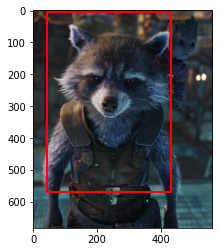

In [86]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()